<a href="https://colab.research.google.com/github/aims-ks/transformer-tutorials/blob/main/DINOv2/Predict_DINOv2_Reefscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets
!pip install -q evaluate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import numpy as np

dataset = load_dataset("aimsks/ts-aims-reefscapes-marine-features")
id2label = {
    0: "water",
    1: "reef",
    2: "land",
    3: "sandbank"
}
print(id2label)

from torch.utils.data import Dataset
import torch

class SegmentationDataset(Dataset):
  def __init__(self, dataset, transform):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]

    # Trim off the alpha channel
    original_image = np.array(item["image"])[:,:,:3]

    # Only keep one channel as they are all the same. Also rescale from 0 - 3
    # instead of the original steps of 50. I don't know if this is necessary, but
    # antialiasing might have creates intermediate values.
    original_segmentation_map = (np.array(item["label"])[:,:,0]/50).astype(int)

    transformed = self.transform(image=original_image, mask=original_segmentation_map)
    image, target = torch.tensor(transformed['image']), torch.LongTensor(transformed['mask'])

    # convert to C, H, W
    image = image.permute(2,0,1)

    return image, target, original_image, original_segmentation_map

import albumentations as A

# Calculated from https://github.com/aims-ks/transformer-tutorials/blob/main/Calculate_reefscape_normalisation.ipynb
REEFSCAPE_MEAN = np.array([0.1839, 0.3785, 0.4397])
REEFSCAPE_STD = np.array([0.1389, 0.1073, 0.0956])

train_transform = A.Compose([
    # hadded an issue with an image being too small to crop, PadIfNeeded didn't help...
    # if anyone knows why this is happening I'm happy to read why
    # A.PadIfNeeded(min_height=448, min_width=448),
    # A.CenterCrop(height=448, width=448),
    # A.Resize(width=448, height=448),
    A.RandomCrop(height=448, width=448),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=REEFSCAPE_MEAN, std=REEFSCAPE_STD),
])

val_transform = A.Compose([
    A.CenterCrop(height=448, width=448),
    #A.Resize(width=448, height=448),
    A.Normalize(mean=REEFSCAPE_MEAN, std=REEFSCAPE_STD),

])

train_dataset = SegmentationDataset(dataset["train"], transform=train_transform)
val_dataset = SegmentationDataset(dataset["validation"], transform=val_transform)

from torch.utils.data import DataLoader

def collate_fn(inputs):
    batch = dict()
    batch["pixel_values"] = torch.stack([i[0] for i in inputs], dim=0)
    batch["labels"] = torch.stack([i[1] for i in inputs], dim=0)
    batch["original_images"] = [i[2] for i in inputs]
    batch["original_segmentation_maps"] = [i[3] for i in inputs]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

{0: 'water', 1: 'reef', 2: 'land', 3: 'sandbank'}


In [ ]:
import torch
from transformers import Dinov2Model, Dinov2PreTrainedModel
from transformers.modeling_outputs import SemanticSegmenterOutput


# Model saving/loading path
#model_path = "/content/drive/My Drive/dinov2_segmentation_checkpoint.pth"


class LinearClassifier(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearClassifier, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)


class Dinov2ForSemanticSegmentation(Dinov2PreTrainedModel):
  def __init__(self, config):
    super().__init__(config)

    self.dinov2 = Dinov2Model(config)
    self.classifier = LinearClassifier(config.hidden_size, 32, 32, config.num_labels)

  def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
    # use frozen features
    outputs = self.dinov2(pixel_values,
                            output_hidden_states=output_hidden_states,
                            output_attentions=output_attentions)
    # get the patch embeddings - so we exclude the CLS token
    patch_embeddings = outputs.last_hidden_state[:,1:,:]

    # convert to logits and upsample to the size of the pixel values
    logits = self.classifier(patch_embeddings)
    logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

    loss = None
    if labels is not None:
      # important: we're going to use 0 here as ignore index instead of the default -100
      # as we don't want the model to learn to predict background
      loss_fct = torch.nn.CrossEntropyLoss(ignore_index=0)
      loss = loss_fct(logits.squeeze(), labels.squeeze())

    return SemanticSegmenterOutput(
        loss=loss,
        logits=logits,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )

In [ ]:
from torch.optim import AdamW
from tqdm.auto import tqdm
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 4. Load the pretrained model
model = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", id2label=id2label, num_labels=len(id2label))
for name, param in model.named_parameters():
  if name.startswith("dinov2"):
    param.requires_grad = False

# training hyperparameters
# NOTE: I've just put some random ones here, not optimized at all
# feel free to experiment, see also DINOv2 paper
learning_rate = 5e-5
epochs = 40

#optimizer = AdamW(model.parameters(), lr=learning_rate)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)


# Checkpoint saving/loading path
checkpoint_path = "/content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth"


# put model on GPU (set runtime to GPU in Google Colab)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Attempt to load saved training state
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0

Mounted at /content/drive


Some weights of Dinov2ForSemanticSegmentation were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.weight', 'classifier.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resuming training from epoch 17


In [ ]:
# map every class to a random color
id2color = {k: list(np.random.choice(range(256), size=3)) for k,v in id2label.items()}

def visualize_prediction(image, segmentation_map, predicted_segmentation_map):
    seg_map = (np.array(segmentation_map)[:,:,0]/50).astype(int)
    color_seg = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8) # height, width, 3
    for label, color in id2color.items():
        color_seg[seg_map == label, :] = color

    predicted_color_seg = np.zeros((predicted_segmentation_map.shape[0], predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
    for label, color in id2color.items():
        predicted_color_seg[predicted_segmentation_map == label, :] = color

    # Remove the alpha channel
    sat_img = np.array(image)[:,:,:3]

    # Show image + mask
    img = sat_img * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    predicted_img = sat_img * 0.5 + predicted_color_seg * 0.5
    predicted_img = predicted_img.astype(np.uint8)

    #plt.figure(figsize=(10, 10))
    #plt.imshow(img)
    #plt.show()

    # Create a new figure
    fig, axarr = plt.subplots(1, 2, figsize=(10, 5))

    # Display the images side by side
    axarr[0].imshow(img)
    axarr[0].axis('off')  # Hide axes for first image

    axarr[1].imshow(predicted_img)
    axarr[1].axis('off')  # Hide axes for second image

    plt.tight_layout()
    plt.show()

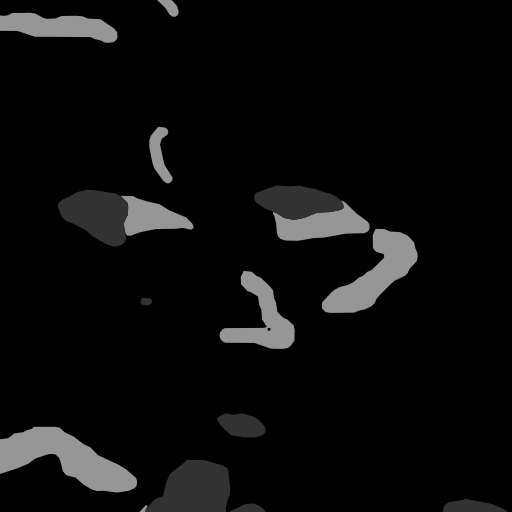

In [ ]:
from PIL import Image

test_image = dataset["validation"][47]["label"]
test_image

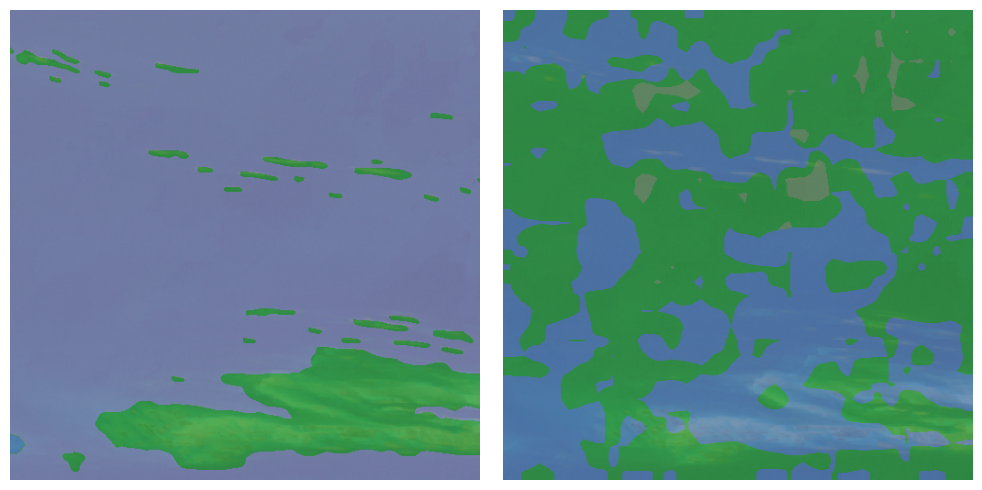

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

ind = 52

test_image = dataset["validation"][ind]["image"]
segmentation_image = dataset["validation"][ind]["label"]

pixel_values = val_transform(image=np.array(test_image)[:,:,:3])["image"]
pixel_values = torch.tensor(pixel_values)
pixel_values = pixel_values.permute(2,0,1).unsqueeze(0) # convert to (batch_size, num_channels, height, width)
# forward pass
with torch.no_grad():
  outputs = model(pixel_values.to(device))
upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                   size=test_image.size[::-1],
                                                   mode="bilinear", align_corners=False)
predicted_map = upsampled_logits.argmax(dim=1)
visualize_prediction(test_image, segmentation_image, predicted_map.squeeze().cpu())